In [1]:
import torch_geometric
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
current_file_path = os.path.abspath('./')
parent_directory = os.path.dirname(current_file_path)
sys.path.append(os.path.join(parent_directory, 'codes'))
from SLAM import *

/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def parse_pdb_chain(pdb_file, chain='A',pos=None, atom_type='CA', nneighbor=32, cal_cb=True):
    """
    ########## Process PDB file ##########
    """
    current_pos = -1000
    X = []
    current_aa = {} # N, CA, C, O, R
    first_aa_type = None
    first_aa_position = None
    with open(pdb_file, 'r') as pdb_f:
        for line in pdb_f:
            if line[21] == chain:
                if first_aa_type is None and line[0:4].strip() == "ATOM":
                    first_aa_type = line[17:20].strip()
                    first_aa_position = int(line[22:26].strip())
                if (line[0:4].strip() == "ATOM" and int(line[22:26].strip()) != current_pos) or line[0:4].strip() == "TER":
                    if current_aa != {}:
                        R_group = []
                        for atom in current_aa:
                            if atom not in ["N", "CA", "C", "O"]:
                                R_group.append(current_aa[atom])
                        if R_group == []:
                            R_group = [current_aa["CA"]]
                        R_group = np.array(R_group).mean(0)
                        X.append([current_aa["N"], current_aa["CA"], current_aa["C"], current_aa["O"], R_group])
                        current_aa = {}
                    if line[0:4].strip() != "TER":
                        current_pos = int(line[22:26].strip())

                if line[0:4].strip() == "ATOM":
                    atom = line[13:16].strip()
                    if atom != "H":
                        xyz = np.array([line[30:38].strip(), line[38:46].strip(), line[46:54].strip()]).astype(np.float32)
                        current_aa[atom] = xyz
    X = np.array(X)
    if cal_cb:
        X = np.concatenate([X, get_cb(X[:,0], X[:,1], X[:,2])[:, None]], 1)
    if pos is not None:
        atom_ind = atom_idx[atom_type] # CA atom
        if pos >= X.shape[0]:
            pos = X.shape[0] - 1
        query_coord = X[pos,atom_ind]
        distances = calculate_distances(X[:,atom_ind,:], query_coord)
        closest_indices = sorted(np.argsort(distances)[:nneighbor])
        X = X[(closest_indices)]
    return X, closest_indices, first_aa_type, first_aa_position  # array shape: [Length, 6, 3] N, CA, C, O, R, CB

def get_graph_fea_chain(pdb_path, pos, chain='A', nneighbor=32, radius=10, atom_type='CA', cal_cb=True):
    X, closest_indices,first_aa_type, first_aa_position = parse_pdb_chain(pdb_path, chain=chain,pos=pos, atom_type=atom_type, nneighbor=nneighbor, cal_cb=cal_cb)
    X = torch.tensor(X).float()
    query_atom = X[:, atom_idx[atom_type]]
    edge_index = radius_graph(query_atom, r=radius, loop=False, max_num_neighbors=nneighbor, num_workers = 4)
    node, edge = get_geo_feat(X, edge_index)
    return Data(x=node, edge_index=edge_index, edge_attr=edge, name=os.path.basename(pdb_path).split('.')[0], near=closest_indices)

def _get_encoding(seq, feature=[BLOSUM62, BINA]):
    alphabet = 'ARNDCQEGHILKMFPSTWYVX'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    sample = ''.join([re.sub(r"[UZOB*]", "X", token) for token in seq])
    # seq = [char_to_int[char] for char in sample]
    max_len = len(sample)
    all_fea = []
    for encoder in feature:
        fea = encoder([sample])
        assert fea.shape[0] == max_len
        all_fea.append(fea)
    return np.hstack(all_fea)
    
def get_all_inputs(seq, pos, tokenizer, pdb_path):
    data = get_graph_fea_chain(pdb_path, pos, nneighbor=32, atom_type='CA', cal_cb=True)
    fea = _get_encoding(seq)
    s = ''.join([token for token in re.sub(r"[UZOB*]", "X", seq.rstrip('*'))])
    max_len = len(s)
    encoded = tokenizer.encode_plus(seq, add_special_tokens=True, padding='max_length', return_token_type_ids=False, pad_to_max_length=True,truncation=True, max_length=max_len, return_tensors='pt')
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    return data, input_ids, attention_mask, torch.tensor(fea, dtype=torch.float)

def get_peptide(pos, window_size, seq, mirror=True):
    """Return peptide based on window_size. Missing residues are padded with X symbol (if mirror == False) or mirroring residues from the other side (if mirror == True)."""
    pos = pos-1
    half_window = int(window_size/2)
    start = pos - half_window
    left_padding = '' if start >= 0 else 'X' * abs(start)
    start = 0 if start < 0 else start
    end = pos + half_window + 1
    right_padding = 'X' * half_window
    end = len(seq) if end + 1 > len(seq) else end
    peptide_ = seq[start:end]
    if mirror:
        if left_padding == '' and right_padding == '':
            peptide = left_padding + peptide_ + right_padding
        elif left_padding == '' and right_padding != '': # mirror left
            peptide = left_padding + peptide_ + peptide_[:len(right_padding)][::-1]
        elif left_padding != '' and right_padding == '': # mirror right
            peptide = peptide_[::-1][:len(left_padding)] + peptide_ + right_padding
        else:
            peptide = None
    else:
        peptide = left_padding + peptide_ + right_padding
    if peptide is not None:
        peptide = peptide[:window_size]
        assert peptide[half_window] == 'K' and len(peptide) == window_size
        return peptide
    else:
        return None

def get_all_k(seqlist, window_size=51):
    peplist = []
    window_size = window_size
    half_window = window_size // 2
    for record in seqlist:
        seq = str(record.seq)
        for m in re.finditer('K', seq):
            pos = m.start() + 1
            pep = get_peptide(pos, window_size, seq, mirror=False)
            if pep is not None:
                peplist.append([f'{pdb_id}|Pred|{pos}|{len(seq)}', pep])
    return peplist

In [3]:
gpu = 0
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')
n_layers = 1
dropout = 0.5
embedding_dim = 32
hidden_dim = 64
out_dim = 32
node_dim = 267
edge_dim = 632
nneighbor = 32
atom_type = 'CA' # CB, R, C, N, O
gnn_layers = 5
encoder_list = ['cnn','lstm','fea', 'gnn', 'plm']
fea_dim = 41
PLM_dim = 1024
window_size = 51
pretrained_model = '../prot_bert/'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, do_lower_case=False, use_fast=False)
BERT_encoder = AutoModel.from_pretrained(pretrained_model, local_files_only=True, output_attentions=False).to(device)
model_file = f'../Models/SLAM_combine/general_struct_plm/best_general_struct_plm_model_epoch.pt'  
model = SLAMNet(BERT_encoder=BERT_encoder, vocab_size=tokenizer.vocab_size, encoder_list=encoder_list,PLM_dim=PLM_dim,win_size=window_size,embedding_dim=embedding_dim, fea_dim=fea_dim, hidden_dim=hidden_dim, out_dim=out_dim,node_dim=node_dim, edge_dim=edge_dim, gnn_layers=gnn_layers,n_layers=n_layers,dropout=dropout).to(device)
model.load_state_dict(torch.load(model_file))

Some weights of the model checkpoint at /mnt/data/zhqin/pretrain_LM/prot_bert/ were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [4]:
pdb_id = '5w49'
chain = 'A'
pdb_path = f'{pdb_id}.pdb'
seq_path = f'{pdb_id}.fa'
first_aa_position = int(parse_pdb_chain(pdb_path, chain=chain,pos=1, atom_type=atom_type, nneighbor=nneighbor, cal_cb=True)[3])
discrepancy = first_aa_position -1
seqlist = [record for record in SeqIO.parse(seq_path, "fasta")]
peplist = get_all_k(seqlist, window_size=window_size)
peplist[:5]

[['5w49|Pred|1|429', 'XXXXXXXXXXXXXXXXXXXXXXXXXKLPYKVADIGLAAWGRKALDIAENEM'],
 ['5w49|Pred|5|429', 'XXXXXXXXXXXXXXXXXXXXXKLPYKVADIGLAAWGRKALDIAENEMPGLM'],
 ['5w49|Pred|17|429', 'XXXXXXXXXKLPYKVADIGLAAWGRKALDIAENEMPGLMRMRERYSASKPL'],
 ['5w49|Pred|40|429', 'GRKALDIAENEMPGLMRMRERYSASKPLKGARIAGCLHMTVETAVLIETLV'],
 ['5w49|Pred|43|429', 'ALDIAENEMPGLMRMRERYSASKPLKGARIAGCLHMTVETAVLIETLVTLG']]

In [5]:
predictions = []
model.eval()
for desc, seq in peplist:
    seq = str(seq)
    tmp = desc.split('|')
    pos = int(tmp[2])
    g, input_ids, attention_mask, feature = get_all_inputs(seq,pos,tokenizer,pdb_path)
    feature = feature.unsqueeze(0).to(device)
    g = g.to(device)
    g.batch = torch.zeros(g.x.shape[0],dtype=torch.int64).to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    pred = model(input_ids=input_ids, attention_mask=attention_mask, feature=feature, g_data=g)
    result = [seq, pos+discrepancy, pred.squeeze().detach().item()]
    predictions.append(result)

In [11]:
threshold = 0.37
case = pd.DataFrame(predictions)
case.columns = ['Sequence', 'Position', 'Scores']
case.to_csv('ahcy_all.csv', index=False, sep='\t')
case.head(3)

,Sequence,Position,Scores
0,XXXXXXXXXXXXXXXXXXXXXXXXXKLPYKVADIGLAAWGRKALDI...,4,0.002205
1,XXXXXXXXXXXXXXXXXXXXXKLPYKVADIGLAAWGRKALDIAENE...,8,0.478325
2,XXXXXXXXXKLPYKVADIGLAAWGRKALDIAENEMPGLMRMRERYS...,20,0.472869


In [7]:
explist = [20,43,188,204,389,405]

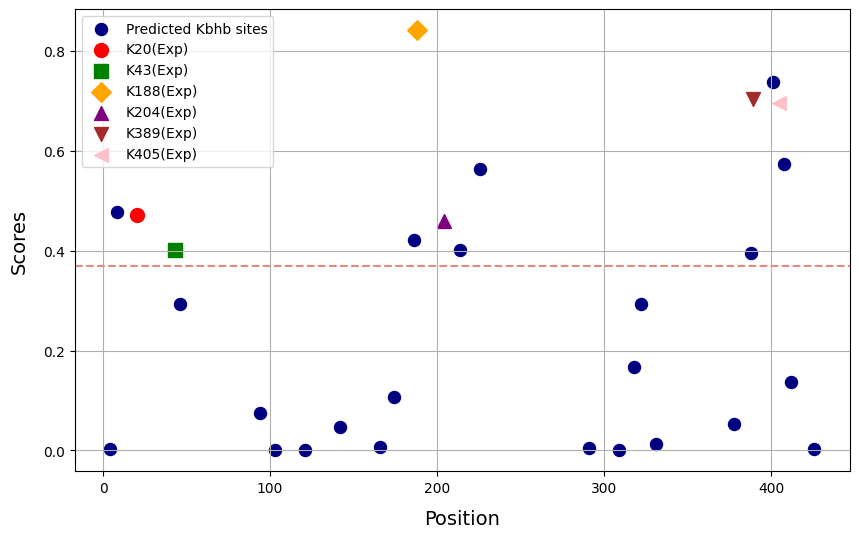

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(case[~case['Position'].isin(explist)]['Position'], case[~case['Position'].isin(explist)]['Scores'], s=75,color='navy', label='Predicted Kbhb sites')
shapes = ['o', 's', 'D', '^', 'v', '<']
colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink']

for i, pos in enumerate(explist):
    subset = case[case['Position'] == pos]
    plt.scatter(subset['Position'], subset['Scores'], color=colors[i], marker=shapes[i], s=100, label=f'K{pos}(Exp)')

plt.xlabel('Position',fontsize=14,labelpad=10)
plt.ylabel('Scores',fontsize=14,labelpad=10)
plt.axhline(y=0.37, color='#DF8B81', linestyle='--')
plt.legend()
plt.grid(True)
plt.savefig('scatter.png', dpi=1000)

In [12]:
kbhb = case[case['Scores']>threshold]
kbhb.to_csv('ahcy_kbhb.csv', index=False, sep='\t')
kbhb

,Sequence,Position,Scores
1,XXXXXXXXXXXXXXXXXXXXXKLPYKVADIGLAAWGRKALDIAENE...,8,0.478325
2,XXXXXXXXXKLPYKVADIGLAAWGRKALDIAENEMPGLMRMRERYS...,20,0.472869
3,GRKALDIAENEMPGLMRMRERYSASKPLKGARIAGCLHMTVETAVL...,43,0.401289
11,VHNLYKMMANGILKVPAINVNDSVTKSKFDNLYGCRESLIDGIKRA...,186,0.422274
12,NLYKMMANGILKVPAINVNDSVTKSKFDNLYGCRESLIDGIKRATD...,188,0.842055
13,NVNDSVTKSKFDNLYGCRESLIDGIKRATDVMIAGKVAVVAGYGDV...,204,0.460173
14,FDNLYGCRESLIDGIKRATDVMIAGKVAVVAGYGDVGKGCAQALRG...,214,0.402376
15,DGIKRATDVMIAGKVAVVAGYGDVGKGCAQALRGFGARVIITEIDP...,226,0.565033
22,TNQVMAQIELWTHPDKYPVGVHFLPKKLDEAVAEAHLGKLNVKLTK...,388,0.396090
23,NQVMAQIELWTHPDKYPVGVHFLPKKLDEAVAEAHLGKLNVKLTKL...,389,0.704376


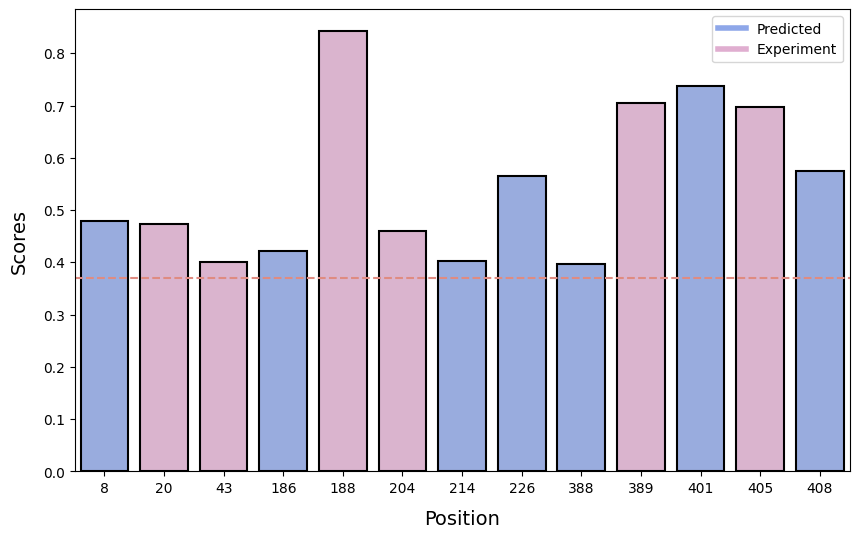

In [10]:
plt.figure(figsize=(10, 6))
palette = []
for pos in kbhb['Position']:
    if pos in explist:
        palette.append('#E0AED0')
    else:
        palette.append('#8EA7E9')
sns.barplot(x='Position', y='Scores', data=kbhb, palette=palette,edgecolor='black', linewidth=1.5)
plt.axhline(y=0.37, color='#DF8B81', linestyle='--')
plt.xlabel('Position',fontsize=14,labelpad=10)
plt.ylabel('Scores',fontsize=14,labelpad=10)
handles = [plt.Line2D([0], [0], color='#8EA7E9', lw=4, label='Predicted'),
           plt.Line2D([0], [0], color='#E0AED0', lw=4, label='Experiment')]
plt.legend(handles=handles)
plt.savefig('bar.png', dpi=1000)